## 1. Usual pre-amble to set up model and import data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import os
import time
from collections import defaultdict
from PIL import Image
from matplotlib.pyplot import imsave

import facenet
import lfw
import foolbox

import mp # previous Jupyter notebook

with open('full_results', 'rb') as f:
    results = pickle.load(f)
    
results['gaussian_noise'] = results['guassian_noise']

tf.Graph().as_default()
sess = tf.Session()
# Load model
model = mp.InceptionResnetV1Model()
# Convert to classifier
model.convert_to_classifier()

# Load pairs of faces and their labels in one-hot encoding
size = 50
faces1, faces2, labels = mp.load_testset(size)
binary_labels = [0 if labels[i][0] == 1 else 1 for i in range(size)]

# Create victims' embeddings using Facenet itself
graph = tf.get_default_graph()
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
feed_dict = {model.face_input: faces2,
              phase_train_placeholder: False}
victims_embeddings = sess.run(
    model.embedding_output, feed_dict=feed_dict)
feed_dict = {model.face_input: faces1,
              phase_train_placeholder: False}
non_victims_embeddings = sess.run(
  model.embedding_output, feed_dict=feed_dict)

sess.close()

Model filename: ../models/20180402-114759/20180402-114759.pb


In [2]:
binary_labels = np.array(binary_labels[:50])
anonymization_total = np.sum(binary_labels == 0)
impersonation_total = np.sum(binary_labels == 1)

print(anonymization_total)
print(impersonation_total)

26
24


In [3]:
import matplotlib.pyplot as plt

In [6]:
for i in range(size):
    im1 = faces1[i]
    plt.imsave('test/faces1/' + str(i) + '.png', im1)
    im2 = faces2[i]
    plt.imsave('test/faces2/' + str(i) + '.png', im2)

## 2. Sample call to AWS Rekognition

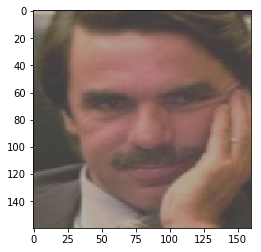

In [7]:
plt.imshow(faces1[0])

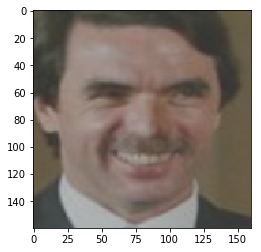

In [8]:
plt.imshow(faces2[0])

In [3]:
import boto3

In [4]:
client=boto3.client('rekognition')

In [35]:
image1=open('test/faces1/0.png', 'rb')
image2=open('test/faces2/0.png', 'rb')

In [36]:
response=client.compare_faces(SourceImage={'Bytes': image1.read()}, TargetImage={'Bytes': image2.read()})

As can be seen below AWS Rekognition gives us a similarity score $s$ between two faces. We will use $s$ as a measure of the confidence of AWS in the correct class prediction when the test pair is two images of the same person ('same') and $1-s$ as the measure of the confidence when the test pair is two images of different people ('not same').

In [37]:
response

{'SourceImageFace': {'BoundingBox': {'Width': 0.7304216623306274,
   'Height': 0.8100289106369019,
   'Left': 0.16757778823375702,
   'Top': 0.10246968269348145},
  'Confidence': 99.99966430664062},
 'FaceMatches': [{'Similarity': 98.82148742675781,
   'Face': {'BoundingBox': {'Width': 0.7208973169326782,
     'Height': 0.8154644966125488,
     'Left': 0.1300012171268463,
     'Top': 0.06833235919475555},
    'Confidence': 99.99966430664062,
    'Landmarks': [{'Type': 'eyeLeft',
      'X': 0.3626232445240021,
      'Y': 0.3961615264415741},
     {'Type': 'eyeRight', 'X': 0.6862460374832153, 'Y': 0.39902231097221375},
     {'Type': 'mouthLeft', 'X': 0.38243138790130615, 'Y': 0.6833714842796326},
     {'Type': 'mouthRight', 'X': 0.6540526747703552, 'Y': 0.6853803992271423},
     {'Type': 'nose', 'X': 0.5333002805709839, 'Y': 0.5622802972793579}],
    'Pose': {'Roll': -1.436773657798767,
     'Yaw': 2.892544984817505,
     'Pitch': 8.505446434020996},
    'Quality': {'Brightness': 67.6668

## 3. Collect baseline results (unperturbed LFW test pairs)

In [5]:
from time import sleep

In [6]:
transferability_results = {}
transferability_results['baseline'] = []

In [1]:
for i in range(50):
    with open('test/faces1/' + str(i) + '.png', 'rb') as image1:
        with open('test/faces2/' + str(i) + '.png', 'rb') as image2:
            response=client.compare_faces(SimilarityThreshold=0, 
                                          SourceImage={'Bytes': image1.read()}, 
                                          TargetImage={'Bytes': image2.read()})
            transferability_results['baseline'].append(response)
            sleep(1)

In [10]:
total_confidence = 0
anonymization_confidence = 0
impersonation_confidence = 0

for i in range(50):
    print('True label: ', 'Same' if binary_labels[i] == 0 else 'Not Same')
    response = transferability_results['baseline'][i]
    confidence = response['FaceMatches'][0]['Similarity'] / 100
    confidence = confidence if binary_labels[i] == 0 else 1 - confidence
    total_confidence += confidence
    anonymization_confidence += (binary_labels[i] == 0) * confidence
    impersonation_confidence += (binary_labels[i] == 1) * confidence
    print('AWS Rekognition Confidence: ', confidence)
    
print('Overall:')
print('Avg Confidence in Correct Decision: ', total_confidence / 50)
print('Avg Confidence in Correct Decision (anon): ', anonymization_confidence / anonymization_total)
print('Avg Confidence in Correct Decision (impersonation): ', impersonation_confidence / impersonation_total)

True label:  Same
AWS Rekognition Confidence:  0.9882148742675781
True label:  Same
AWS Rekognition Confidence:  0.9263311767578125
True label:  Same
AWS Rekognition Confidence:  0.9985054016113282
True label:  Not Same
AWS Rekognition Confidence:  0.9382585382461548
True label:  Same
AWS Rekognition Confidence:  0.9843777465820313
True label:  Same
AWS Rekognition Confidence:  0.9998371124267578
True label:  Not Same
AWS Rekognition Confidence:  0.8208400726318359
True label:  Not Same
AWS Rekognition Confidence:  0.9197218608856201
True label:  Not Same
AWS Rekognition Confidence:  0.941724739074707
True label:  Same
AWS Rekognition Confidence:  0.9929012298583985
True label:  Not Same
AWS Rekognition Confidence:  0.8030994796752929
True label:  Not Same
AWS Rekognition Confidence:  0.8607989406585693
True label:  Not Same
AWS Rekognition Confidence:  0.904282112121582
True label:  Not Same
AWS Rekognition Confidence:  0.8793562412261963
True label:  Not Same
AWS Rekognition Confiden

## 4. Collect Rekognition confidence scores on attacked images

In [52]:
for i in range(50):
    im1_gaussian = results['gaussian_noise']['adversarials'][i]
    if im1_gaussian is not None:
        plt.imsave('test/faces1-gaussian/' + str(i) + '.png', im1_gaussian)

    im1_uniform = results['uniform_noise']['adversarials'][i]
    if im1_uniform is not None:
        plt.imsave('test/faces1-uniform/' + str(i) + '.png', im1_uniform)
    
    im1_fgsm = results['fgsm']['adversarials'][i]
    if im1_fgsm is not None:
        plt.imsave('test/faces1-fgsm/' + str(i) + '.png', im1_fgsm)
    
    im1_deepfool = results['deep_fool']['adversarials'][i]
    if im1_deepfool is not None:
        plt.imsave('test/faces1-deepfool/' + str(i) + '.png', im1_deepfool)

In [11]:
def collect_responses(attack_folder, attack_name):
    transferability_results[attack_name] = []
    for i in range(50):
        if (results[attack_name]['adversarials'][i] is not None):
            with open(attack_folder + str(i) + '.png', 'rb') as image1:
                with open('test/faces2/' + str(i) + '.png', 'rb') as image2:
                    sleep(1)
                    try: 
                        response=client.compare_faces(SimilarityThreshold=0, 
                                                      SourceImage={'Bytes': image1.read()}, 
                                                      TargetImage={'Bytes': image2.read()})
                        transferability_results[attack_name].append(response)
                    except:
                        # this happens when Rekognition does not detect a face at all in image
                        transferability_results[attack_name].append(-1)
        else:
            transferability_results[attack_name].append(None)
        print('Done with ', i)

We also collect results for images where the defense is applied but no attack was made, just to validate that the defenses are reasonable in general. You wouldn't want, for instance, that a defense decreases confidence in correct classification for unperturbed pairs (i.e. decreasing system accuracy for honest participants).

In [15]:
results['mean-preprocessing'] = {}
results['n2n-preprocessing'] = {}
results['mean-preprocessing']['adversarials'] = [0] * 50
results['n2n-preprocessing']['adversarials'] = [0] * 50

In [78]:
collect_responses('test/faces1-deepfool/', 'deep_fool')
collect_responses('test/faces1-fgsm/', 'fgsm')
collect_responses('test/faces1-uniform/', 'uniform_noise')
collect_responses('test/faces1-gaussian/', 'gaussian_noise')

In [14]:
collect_responses('test/faces1-mean/', 'mean-preprocessing')
collect_responses('test/faces1-n2n/', 'n2n-preprocessing')

In [16]:
def analyze_responses(attack_name, verbose=False):
    print(attack_name)
    total_confidence = 0
    anonymization_confidence = 0
    impersonation_confidence = 0
    anonymization_denominator = 0
    impersonation_denominator = 0
    total_denominator = 0

    for i in range(50):
        if (results[attack_name]['adversarials'][i] is not None):
            if verbose:
                print('True label: ', 'Same' if binary_labels[i] == 0 else 'Not Same')
            response = transferability_results[attack_name][i]
            if response == -1:
                confidence = 0
            else:
                confidence = response['FaceMatches'][0]['Similarity'] / 100
                confidence = confidence if binary_labels[i] == 0 else 1 - confidence
            total_confidence += confidence
            anonymization_confidence += (binary_labels[i] == 0) * confidence
            impersonation_confidence += (binary_labels[i] == 1) * confidence
            if verbose:
                print('AWS Rekognition Confidence: ', confidence)
            total_denominator += 1
            anonymization_denominator += (binary_labels[i] == 0)
            impersonation_denominator += (binary_labels[i] == 1)
        elif verbose:
            print('No successful attack image for this test image')

    print('Avg Confidence in Correct Decision: ', total_confidence / total_denominator)
    print('Avg Confidence (anonymization subtask): ', anonymization_confidence / anonymization_denominator)
    print('# Anonymization attack images for subtask: ', anonymization_denominator)
    if (impersonation_denominator > 0):
        print('Avg Confidence (impersonation subtask): ', impersonation_confidence / impersonation_denominator)
        print('# Impersonation attack images for subtask: ', impersonation_denominator)
    else:
        print('No successful impersonation attack images')

In [86]:
analyze_responses('deep_fool')
analyze_responses('fgsm')
analyze_responses('uniform_noise')
analyze_responses('gaussian_noise')

deep_fool
Avg Confidence in Correct Decision:  0.8802782636642454
Avg Confidence (anonymization subtask):  0.9668071013230547
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.7865386895338694
# Impersonation attack images for subtask:  24
fgsm
Avg Confidence in Correct Decision:  0.8945796451568605
Avg Confidence (anonymization subtask):  0.9746136885422927
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.7850593752610058
# Impersonation attack images for subtask:  19
uniform_noise
Avg Confidence in Correct Decision:  0.5811944110576923
Avg Confidence (anonymization subtask):  0.5811944110576923
# Anonymization attack images for subtask:  26
No successful impersonation attack images
gaussian_noise
Avg Confidence in Correct Decision:  0.6304074449892397
Avg Confidence (anonymization subtask):  0.6197481624896709
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.90754

In [18]:
analyze_responses('mean-preprocessing')
analyze_responses('n2n-preprocessing')

mean-preprocessing
Avg Confidence in Correct Decision:  0.9326610475540165
Avg Confidence (anonymization subtask):  0.9839612403282753
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.8770858387152353
# Impersonation attack images for subtask:  24
n2n-preprocessing
Avg Confidence in Correct Decision:  0.9332592787742616
Avg Confidence (anonymization subtask):  0.9862346326387846
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.8758693120876946
# Impersonation attack images for subtask:  24


In [88]:
with open('transferability_results', 'wb+') as f:
    pickle.dump(transferability_results, f)

In [9]:
with open('transferability_results', 'rb') as f:
    transferability_results = pickle.load(f)

## 5. Collect confidence scores for defended images

In [11]:
import cv2

In [13]:
filter_size = 3

for i in range(50):
    im1_gaussian = results['gaussian_noise']['adversarials'][i]
    if im1_gaussian is not None:
        im1_gaussian = cv2.blur(im1_gaussian, (filter_size, filter_size))
        plt.imsave('test/faces1-gaussian-mean/' + str(i) + '.png', im1_gaussian)

    im1_uniform = results['uniform_noise']['adversarials'][i]
    if im1_uniform is not None:
        im1_uniform = cv2.blur(im1_uniform, (filter_size, filter_size))
        plt.imsave('test/faces1-uniform-mean/' + str(i) + '.png', im1_uniform)
    
    im1_fgsm = results['fgsm']['adversarials'][i]
    if im1_fgsm is not None:
        im1_fgsm = cv2.blur(im1_fgsm, (filter_size, filter_size))
        plt.imsave('test/faces1-fgsm-mean/' + str(i) + '.png', im1_fgsm)
    
    im1_deepfool = results['deep_fool']['adversarials'][i]
    if im1_deepfool is not None:
        im1_deepfool = cv2.blur(im1_deepfool, (filter_size, filter_size))
        plt.imsave('test/faces1-deepfool-mean/' + str(i) + '.png', im1_deepfool)

In [2]:
transferability_results['deep_fool-old'] = transferability_results['deep_fool']
transferability_results['fgsm-old'] = transferability_results['fgsm']
transferability_results['uniform_noise-old'] = transferability_results['uniform_noise']
transferability_results['gaussian_noise-old'] = transferability_results['gaussian_noise']

collect_responses('test/faces1-deepfool-mean/', 'deep_fool')
collect_responses('test/faces1-fgsm-mean/', 'fgsm')
collect_responses('test/faces1-uniform-mean/', 'uniform_noise')
collect_responses('test/faces1-gaussian-mean/', 'gaussian_noise')

In [15]:
print("With mean filter defense before passing to AWS Rekognition")
analyze_responses('deep_fool')
analyze_responses('fgsm')
analyze_responses('uniform_noise')
analyze_responses('gaussian_noise')

With mean filter defense before passing to AWS Rekognition
deep_fool
Avg Confidence in Correct Decision:  0.8822692694663999
Avg Confidence (anonymization subtask):  0.9664620824960561
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.7910603886842728
# Impersonation attack images for subtask:  24
fgsm
Avg Confidence in Correct Decision:  0.8975047336154511
Avg Confidence (anonymization subtask):  0.9706307924710788
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.797437495181435
# Impersonation attack images for subtask:  19
uniform_noise
Avg Confidence in Correct Decision:  0.9215616915776178
Avg Confidence (anonymization subtask):  0.9215616915776178
# Anonymization attack images for subtask:  26
No successful impersonation attack images
gaussian_noise
Avg Confidence in Correct Decision:  0.9214886524059154
Avg Confidence (anonymization subtask):  0.9214499840369592
# Anonymization attack images for sub

In [3]:
transferability_results['deep_fool-old'] = transferability_results['deep_fool']
transferability_results['fgsm-old'] = transferability_results['fgsm']
transferability_results['uniform_noise-old'] = transferability_results['uniform_noise']
transferability_results['gaussian_noise-old'] = transferability_results['gaussian_noise']

collect_responses('test/faces1-deepfool-n2n/', 'deep_fool')
collect_responses('test/faces1-fgsm-n2n/', 'fgsm')
collect_responses('test/faces1-uniform-n2n/', 'uniform_noise')
collect_responses('test/faces1-gaussian-n2n/', 'gaussian_noise')

In [11]:
print("With N2N defense before passing to AWS Rekognition")
analyze_responses('deep_fool')
analyze_responses('fgsm')
analyze_responses('uniform_noise')
analyze_responses('gaussian_noise')

With N2N defense before passing to AWS Rekognition
deep_fool
Avg Confidence in Correct Decision:  0.8809683878898622
Avg Confidence (anonymization subtask):  0.9670898320124698
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.7876701567570367
# Impersonation attack images for subtask:  24
fgsm
Avg Confidence in Correct Decision:  0.8955895294613307
Avg Confidence (anonymization subtask):  0.9737968562199519
# Anonymization attack images for subtask:  26
Avg Confidence (impersonation subtask):  0.7885689770547967
# Impersonation attack images for subtask:  19
uniform_noise
Avg Confidence in Correct Decision:  0.9463768474872296
Avg Confidence (anonymization subtask):  0.9463768474872296
# Anonymization attack images for subtask:  26
No successful impersonation attack images
gaussian_noise
Avg Confidence in Correct Decision:  0.9446876084363021
Avg Confidence (anonymization subtask):  0.9456825667161208
# Anonymization attack images for subtask:  